#Question 1

In [ ]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
α       113.744  2.006   109.644    117.544      0.084    0.059     576.0   
β         0.908  0.044     0.824      0.999      0.002    0.001     573.0   
σ         5.102  0.192     4.709      5.460      0.007    0.005     834.0   
μ[0]    157.169  0.298   156.540    157.707      0.008    0.005    1522.0   
μ[1]    146.873  0.459   145.938    147.735      0.017    0.012     736.0   
...         ...    ...       ...        ...        ...      ...       ...   
μ[347]  156.448  0.285   155.883    156.988      0.007    0.005    1686.0   
μ[348]  144.839  0.542   143.788    145.887      0.021    0.015     674.0   
μ[349]  161.107  0.419   160.328    161.969      0.014    0.010     872.0   
μ[350]  162.832  0.487   161.914    163.804      0.017    0.012     775.0   
μ[351]  161.442  0.432   160.597    162.282      0.015    0.010     849.0   

        ess_tail  r_hat  
α          594.0    1.0  
β          586.0    1.0

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (355) in plot_posterior, generating only 40 plots
  warnings.warn(


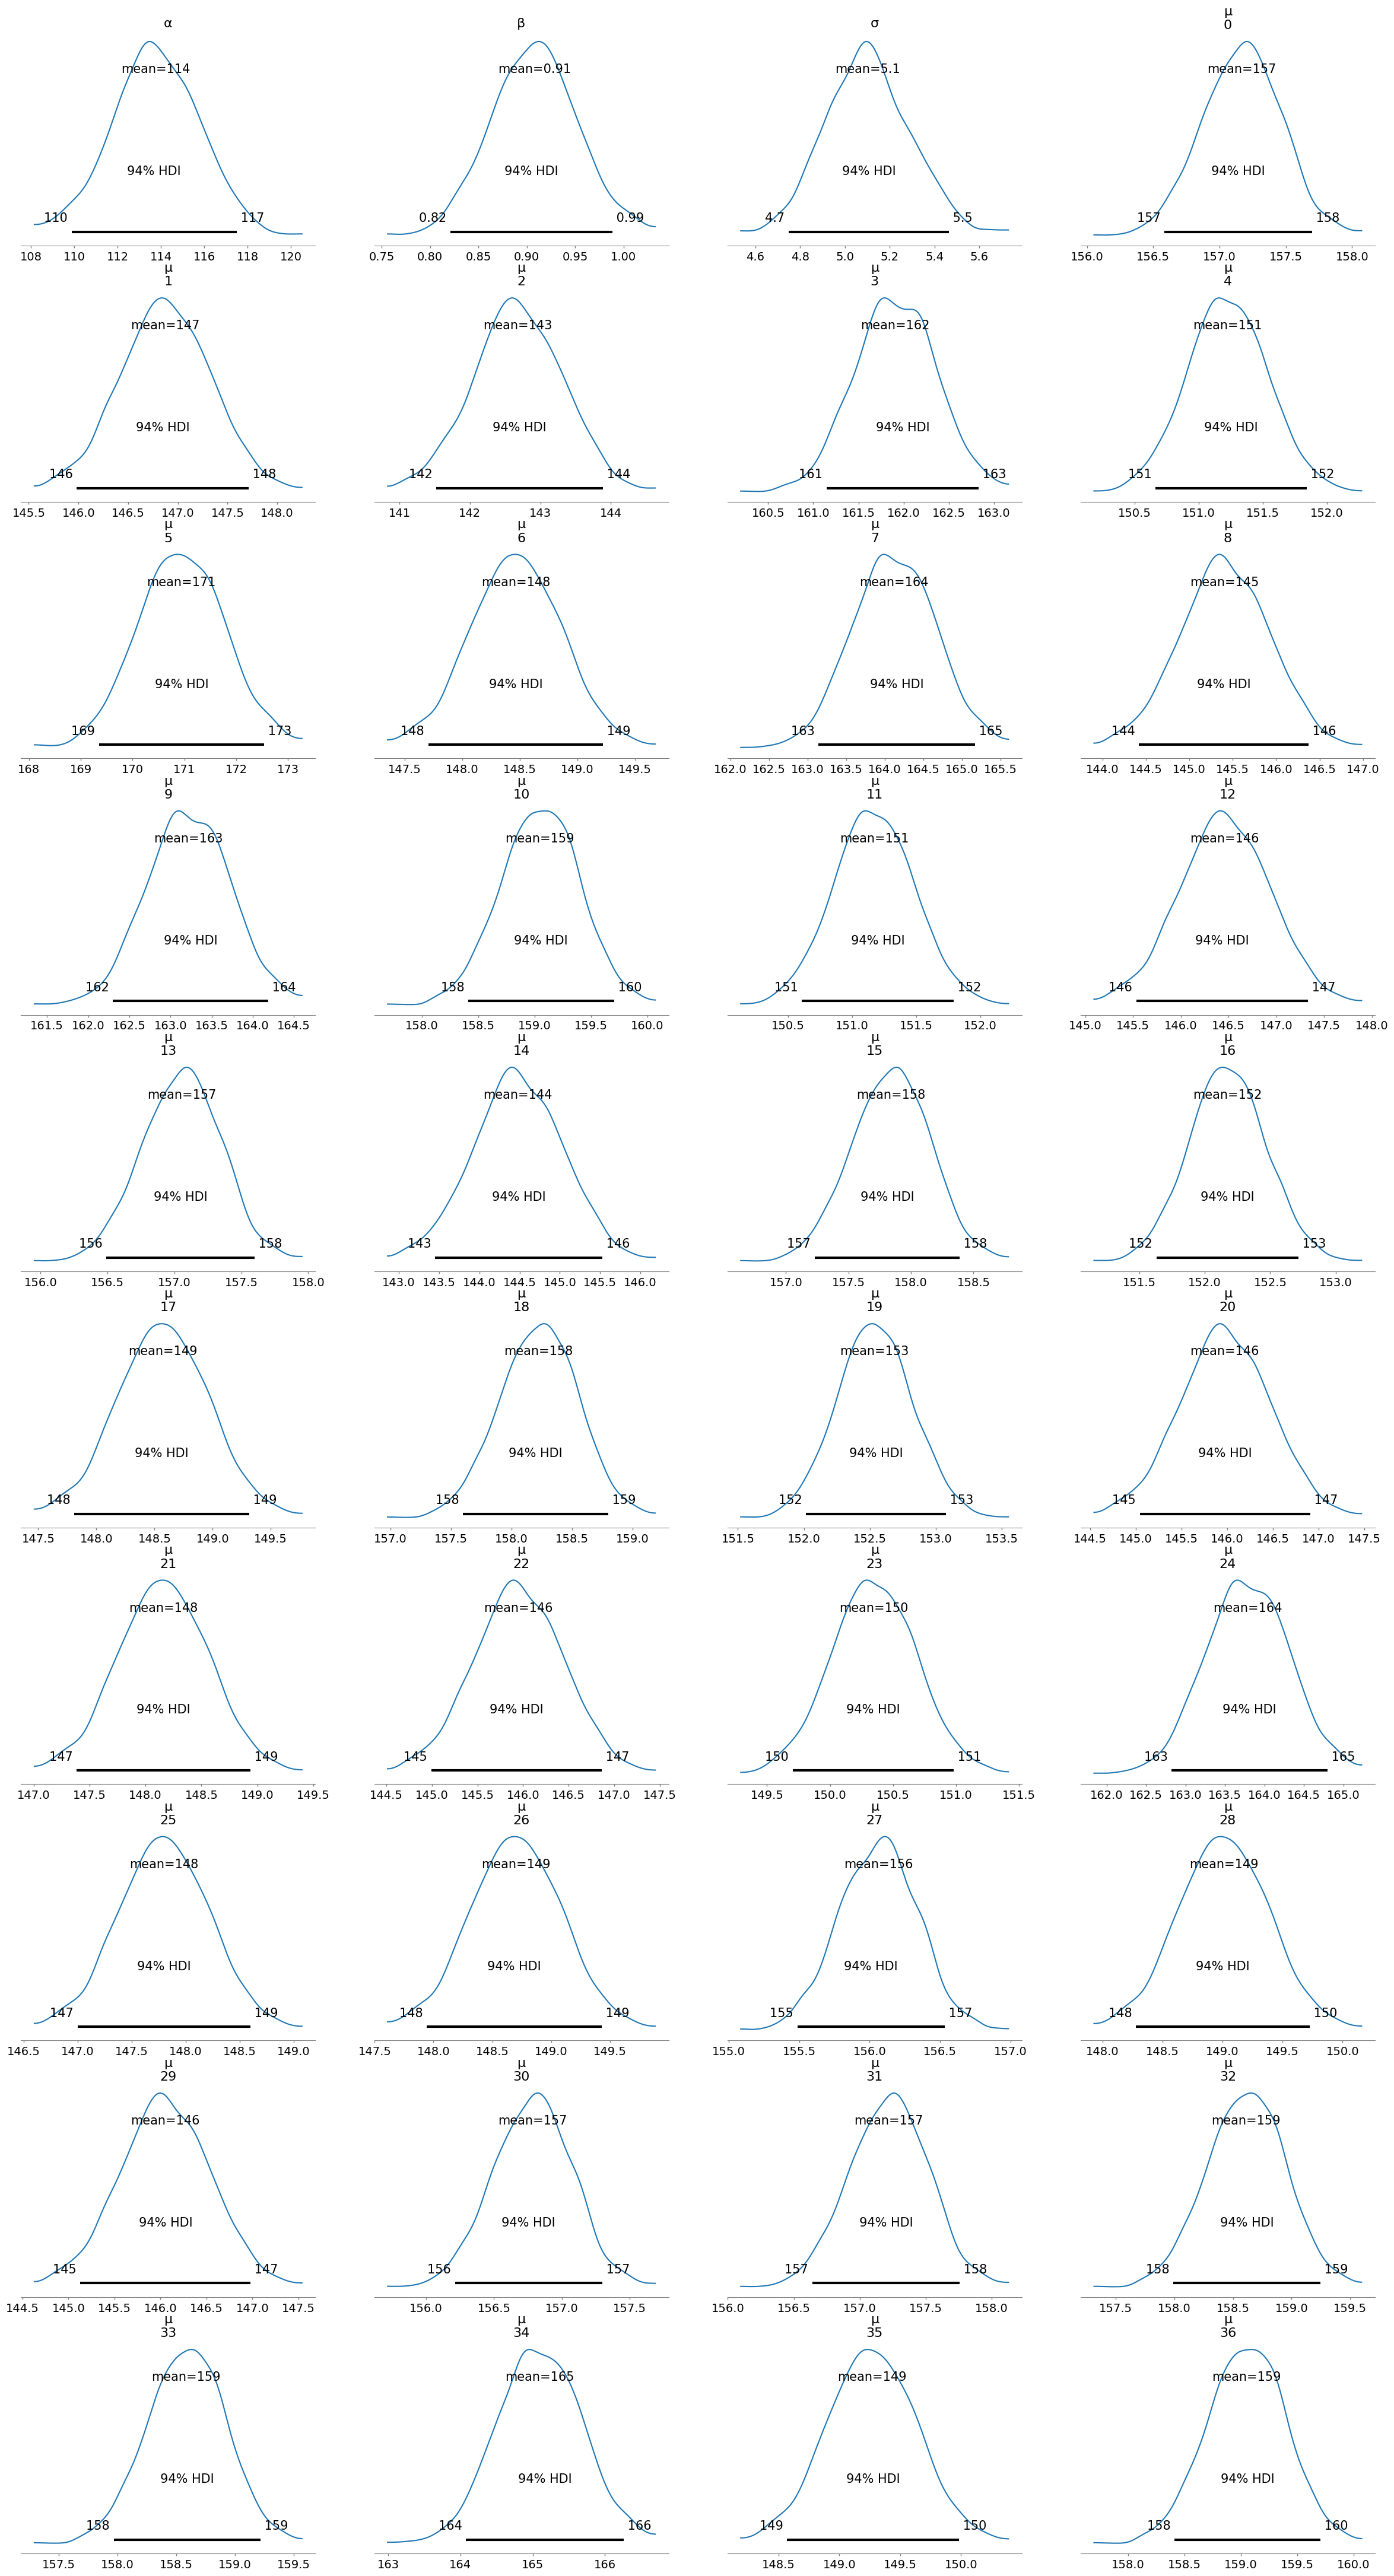

Posterior mean α: <xarray.DataArray 'α' ()>
array(114.14661579)
Posterior mean β: <xarray.DataArray 'β' ()>
array(0.89891439)
x_plot: <xarray.DataArray (x: 100)>
array([31.071052  , 31.39349177, 31.71593154, 32.0383713 , 32.36081107,
       32.68325084, 33.00569061, 33.32813037, 33.65057014, 33.97300991,
       34.29544968, 34.61788944, 34.94032921, 35.26276898, 35.58520875,
       35.90764852, 36.23008828, 36.55252805, 36.87496782, 37.19740759,
       37.51984735, 37.84228712, 38.16472689, 38.48716666, 38.80960642,
       39.13204619, 39.45448596, 39.77692573, 40.09936549, 40.42180526,
       40.74424503, 41.0666848 , 41.38912457, 41.71156433, 42.0340041 ,
       42.35644387, 42.67888364, 43.0013234 , 43.32376317, 43.64620294,
       43.96864271, 44.29108247, 44.61352224, 44.93596201, 45.25840178,
       45.58084155, 45.90328131, 46.22572108, 46.54816085, 46.87060062,
       47.19304038, 47.51548015, 47.83791992, 48.16035969, 48.48279945,
       48.80523922, 49.12767899, 49.45011876, 

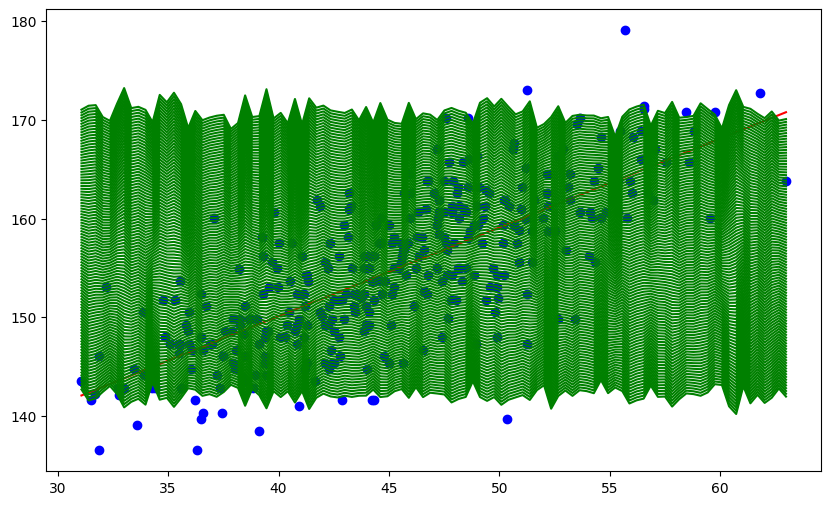

In [ ]:
url = 'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv'
data = pd.read_csv(url,sep=';')

# Filter out subjects younger than 18 years old
adults = data[data['age'] >= 18]

# Extract the relevant columns
weight = adults['weight'].values
height = adults['height'].values

with pm.Model() as model:
    # Priors for intercept (α) and slope (β)
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfCauchy("σ", 10)

    # Linear model
    μ = pm.Deterministic("μ", α + β * weight)
    weight_data = pm.MutableData("weight", weight)

    # Likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=height)

    # Sample from the posterior
    idata = pm.sample()

# Step 3: Analyze and interpret the results
# Display a summary of the posterior distributions
print(az.summary(idata, hdi_prob=0.95))

# Plot the posterior distributions
az.plot_posterior(idata)
plt.show()

# Plot the regression line with the data
posterior = az.extract(idata,num_samples = 100)
x_plot = xr.DataArray(
    np.linspace(adults['weight'].min(), adults['weight'].max(), 100),
    dims=["x"],
)
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot
lines = posterior["α"] + posterior["β"] * x_plot
hdi_lines = az.hdi(idata.posterior["μ"])
print("Posterior mean α:", posterior["α"].mean())
print("Posterior mean β:", posterior["β"].mean())
print("x_plot:", x_plot)
print("mean_line:", mean_line)
print("lines:", lines)
print("HDI lines:", hdi_lines)

# Plot data and regression lines
plt.figure(figsize=(10, 6))
plt.scatter(weight, height, c='blue', label='Data')
plt.plot(x_plot, mean_line, color='red', label='Mean regression line')
plt.plot(x_plot, lines, color='green', label='Regression line')
plt.show()

#Question 2

In [ ]:
## Step 1: Set up pm.MutableData with the new weights
new_weights = np.array([45.73, 65.8, 54.2, 32.59])
with model:
    pm.set_data({"weight": new_weights})

    # Step 2: Generate posterior predictive samples
    ppc = pm.sample_posterior_predictive(idata)
    y_ppc = ppc.posterior_predictive["y_pred"]

# Step 3: Calculate the 50% and 94% HDIs for the predictions
hdi_50 = az.hdi(y_ppc, hdi_prob=0.50)
hdi_94 = az.hdi(y_ppc, hdi_prob=0.94)

# Print the results
for i, weight in enumerate(new_weights):
    print(f"Weight: {weight} kg")
    print(f"Predicted height (mean): {y_ppc.mean(dim=('chain', 'draw')).values[i]:.2f} cm")
    # Access values of the xarray Dataset correctly - the HDI is stored as coordinate values
    print(f"50% HDI: {hdi_50.isel({'hdi_dim': 0}).values[i]} - {hdi_50.isel({'hdi_dim': 1}).values[i]}")
    print(f"94% HDI: {hdi_94.isel({'hdi_dim': 0}).values[i]} - {hdi_94.isel({'hdi_dim': 1}).values[i]}")
    print()

Weight: 45.73 kg
Predicted height (mean): 157.13 cm


ValueError: Dimensions {'hdi_dim'} do not exist. Expected one or more of Frozen({'y_pred_dim_2': 352, 'hdi': 2})

#Question 3

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load the dataset from the World Bank
!wget 'https://databank.worldbank.org/data/download/WDI_csv.zip'
!unzip WDI_csv.zip

# Read the extracted CSV file
df = pd.read_csv('WDICSV.csv', skiprows=4)

# Select relevant columns and filter the data
data = df[['Country Name', '2019 [YR2019]', 'NY.GDP.PCAP.CD', 'SP.DYN.LE00.IN']].dropna()
data.columns = ['Country', 'Year', 'GDP_per_capita', 'Life_expectancy']

# Convert GDP_per_capita and Life_expectancy to numeric values
data['GDP_per_capita'] = pd.to_numeric(data['GDP_per_capita'], errors='coerce')
data['Life_expectancy'] = pd.to_numeric(data['Life_expectancy'], errors='coerce')

# Remove rows with missing values
data = data.dropna()

# Extract the variables
x = data['GDP_per_capita'].values
y = data['Life_expectancy'].values

# Display the first few rows of the filtered data
print(data.head())

with pm.Model() as model:
    # Priors for intercept (α) and slope (β)
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfCauchy("σ", 10)

    # Linear model
    μ = pm.Deterministic("μ", α + β * x)

    # Likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y)

    # Sample from the posterior
    idata = pm.sample()

# Step 4: Analyze and Interpret the Results
# Display a summary of the posterior distributions
print(az.summary(idata, hdi_prob=0.95))

# Plot the posterior distributions
az.plot_posterior(idata)
plt.show()

# Plot the regression line with the data
posterior_samples = az.extract(idata)
α_samples = posterior_samples.posterior['α'].values.flatten()
β_samples = posterior_samples.posterior['β'].values.flatten()

# Generate regression lines based on posterior samples
x_range = np.linspace(x.min(), x.max(), 100)
y_lines = np.array([α_samples[i] + β_samples[i] * x_range for i in range(len(α_samples))])

# Plot data and regression lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='blue', label='Data')
plt.plot(x_range, y_lines.T, color='red', alpha=0.01)
plt.xlabel('GDP per Capita')
plt.ylabel('Life Expectancy')
plt.title('GDP per Capita vs Life Expectancy with Bayesian Linear Regression Lines')
plt.legend()
plt.show()



--2024-07-22 13:11:40--  https://databank.worldbank.org/data/download/WDI_csv.zip
Resolving databank.worldbank.org (databank.worldbank.org)... 104.18.23.34, 104.18.22.34, 2606:4700::6812:1622, ...
Connecting to databank.worldbank.org (databank.worldbank.org)|104.18.23.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://databankfiles.worldbank.org/public/ddpext_download/WDI_csv.zip [following]
--2024-07-22 13:11:40--  https://databankfiles.worldbank.org/public/ddpext_download/WDI_csv.zip
Resolving databankfiles.worldbank.org (databankfiles.worldbank.org)... 13.107.246.40, 2620:1ec:bdf::40
Connecting to databankfiles.worldbank.org (databankfiles.worldbank.org)|13.107.246.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267402945 (255M) [application/x-zip-compressed]
Saving to: ‘WDI_csv.zip.2’

WDI_csv.zip.2       100%[===================>] 255.01M  78.4MB/s    in 3.3s    

2024-07-22 13:11:43 (78.3 MB/s) - ‘WDI